In [1]:
%pylab inline
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
from shapely.geometry import Point,LineString
from IPython.display import display
from pygeocoder import Geocoder
import numpy as np
import googlemaps,csv,math,os,re
from collections import Counter
from functools import reduce
from operator import itemgetter
import calendar

Populating the interactive namespace from numpy and matplotlib


### Load the data

In [ ]:
ph_str_gpd = gpd.read_file('data/Street_Centerline_qgis3.geojson')
purp = gpd.read_file('data/tripbytrip_rd2_geojson.geojson')
purp = purp[purp.geometry.type=="LineString"]
purp.reset_index(inplace=True,drop=True)
purp.head()

In [ ]:
ph_str_gpd.head().T

In [ ]:
new_ph.head().T

### Point to Segment

In [ ]:
# coding=utf-8
import geopandas as gp
from shapely.geometry import Point, LineString, Polygon

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    from math import radians, cos, sin, asin, sqrt
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    m = km * 1000
    return m


def ptfromln(pt, ln):
    """
    project pt to ln, compute haversine distance between projected pt and pt
    :param pt: shapely.geometry.Point, (lon, lat) point
    :param ln: shapely.geometry.LineString, [(lon,lat)] points
    :return: distance in meters
    """
    n_pt = ln.interpolate(ln.project(pt))
    lon1, lat1 = n_pt.coords[0]
    lon2, lat2 = pt.coords[0]
    return haversine(lon1, lat1, lon2, lat2)

def crs_prepossess(gpdf, init_crs, bfr_crs):
    """
    create a shallow copy of gpdf; check the init crs of gpdf, if None, assign init_crs; change crs of copy to bfr_crs
    :param gpdf: geopandas.GeoDataFrame
    :param init_crs: init_crs epsg code
    :param bfr_crs: target crs epsg code used for buffering
    :return: a shallow copy of gpdf in bfr_crs
    """
    gpdf_crs = gpdf.copy()
    if gpdf_crs.crs == None:
        gpdf_crs.crs = {'init': u'epsg:{}'.format(init_crs)}
    return gpdf_crs.to_crs(epsg=bfr_crs)


# ########## functions assigning ln(segment) to objs #############
def pts2segs(pts, lns, bfr_crs, init_crs=4326, close_jn_dist=5, far_jn_dist=20):
    """
    1. close jn: buffer pts in bfr_crs with close_jn_dist, use sjoin to find segment(s) intersected with buffered pts
    2. far jn: for pts without any segment in close jn, buffer them with far_jn_dist and find nearest segment
    :param pts: geopandas.GeoDataFrame
    :param lns: geopandas.GeoDataFrame
    :param bfr_crs: target crs epsg code used for buffering
    :param init_crs: init_crs epsg code, default 4326(lat lon)
    :param close_jn_dist: close join distance, allowing multiple segments for one point(assumed as intersection)
    :param far_jn_dist: far join distance, find the nearest segment for one point
    :return: pandas.DataFrame, columns=[pt_index, ln_index]
    """

    import pandas as pd
    index_pt, index_ln = 'index_pt', 'index_ln'

    lns_crs = crs_prepossess(lns, init_crs, bfr_crs)
    pts_crs = crs_prepossess(pts, init_crs, bfr_crs)

    close_jn = pts_crs.copy()
    close_jn.geometry = close_jn.buffer(close_jn_dist)
    close_jn = gp.tools.sjoin(close_jn, lns_crs)[['index_right']]

    close_jn_pts = set(pd.unique(close_jn.index))
    far_jn = pts_crs[~pts_crs.index.isin(close_jn_pts)].copy()
    
    if not far_jn.empty:
        far_jn.geometry = far_jn.buffer(far_jn_dist)
        far_jn = gp.tools.sjoin(far_jn, lns_crs)[['index_right']]
        # calculate haversine distance
        far_jn = pd.merge(lns[['geometry']], far_jn, left_index=True, right_on=['index_right'])
        far_jn = pd.merge(pts[['geometry']], far_jn, left_index=True, right_index=True)
        far_jn['dis'] = far_jn.apply(lambda x: ptfromln(x.geometry_x, x.geometry_y), axis=1)
        # keep ln with minimum distance to pt
        far_jn = far_jn.groupby(level=0).apply(lambda x: x.iloc[x.dis.values.argmin()][['index_right']])
        pts_has_ln = close_jn.append(far_jn).reset_index()
    else:
        pts_has_ln = close_jn.reset_index()

    pts_has_ln.columns = [index_pt, index_ln]

    pts_no_ln = pts[~pts.index.isin(pd.unique(pts_has_ln[index_pt]))].copy()
    return pts_has_ln, pts_no_ln


if __name__ == '__main__':
    import geopandas as gp
    # points are (lon, lat)
    from shapely.geometry import Point
#     lonlats = list(purp.geometry[0].coords)
    pts = [Point(lonlat) for lonlat in new]
    pts_gpdf = gp.GeoDataFrame(pts, columns=['geometry'])
    # get segment index of segs for each point
    pts_segs_idx, pts_no_segs = pts2segs(pts_gpdf, ph_str_gpd, bfr_crs=3559, init_crs=4326, close_jn_dist=1, far_jn_dist=30)
    # get the STREETSEGID for each point
    pts_segids = pts_segs_idx.merge(ph_str_gpd[['SEG_ID']], left_on=['index_ln'], right_index=True)
    pts_segids.sort_values(by=['index_pt'],inplace=True)
    pts_segids.reset_index(inplace=True,drop=True)
    pts_segids.head().T


In [ ]:
pts_segids[(pts_segids['index_pt']>=20)&(pts_segids['index_pt']<=25)]

In [ ]:
pt_idx = [0,1,2,3,4]
for ptx in pt_idx:
    pt = pts_gpdf.geometry[ptx]

    # the segments that are near pt 45
    seg_indices = pts_segids[(pts_segids['index_pt']==ptx)].index_ln
    print("Point Index: "+str(ptx))
    temp = ph_str_gpd.loc[seg_indices]['geometry'].index
    temp2 = ph_str_gpd.loc[seg_indices]['geometry'].apply(lambda x: ptfromln(pt, x))
    temp3 = ph_str_gpd.loc[seg_indices]['SEG_ID']
    temp = sorted(list(zip(temp,temp3,temp2)),key=itemgetter(1))
    for val in temp:
        print(val)

In [ ]:
pts_segids[(pts_segids['index_pt']>=44)&(pts_segids['index_pt']<=46)]

In [ ]:
pt_idx = 45
pt = pts_gpdf.geometry[pt_idx]

# the segments that are near pt 45
seg_indices = list(pts_segids[(pts_segids['index_pt']==pt_idx)].index_ln)
seg_indices
temp = ph_str_gpd.loc[seg_indices]['geometry'].index
temp2 = ph_str_gpd.loc[seg_indices]['geometry'].apply(lambda x: ptfromln(pt, x))
sorted(list(zip(temp,temp2)),key=itemgetter(1))

In [ ]:
# the pt with index 45
pt_idx = [44,45,46]
for ptx in pt_idx:
    pt = pts_gpdf.geometry[ptx]

    # the segments that are near pt 45
    seg_indices = pts_segids[(pts_segids['index_pt']==ptx)].index_ln
    print("Point Index: "+str(ptx))
    temp = ph_str_gpd.loc[seg_indices]['geometry'].index
    temp2 = ph_str_gpd.loc[seg_indices]['geometry'].apply(lambda x: ptfromln(pt, x))
    temp3 = ph_str_gpd.loc[seg_indices]['SEG_ID']
    temp = sorted(list(zip(temp,temp3,temp2)),key=itemgetter(1))
    for val in temp:
        print(val)


In [ ]:
start = 50
end = 67
temp = pts_segids[(pts_segids['index_pt']>=start)&(pts_segids['index_pt']<=end)].index_ln
inpt = ph_str_gpd.iloc[temp]
otpt = pts[start:end+1]
# gpdfs = [inpt, gpd.GeoDataFrame(otpt,columns=['geometry'])]
gpdfs = [ph_str_gpd, gpd.GeoDataFrame(pts,columns=['geometry'])]
create_map_visualization(html_title, file_path, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)

In [ ]:
from leaflet_creation import create_map_visualization
html_title = 'openstreetmap elements'
file_path = ''
file_name = 'test creation of leaflet'
lon, lat = -75.17445310502671, 39.964070156312744  #D.C.
zoom = 12
init_layers = ['streets', 'stsg']
map_layers = ['light','streets', 'satellite']
binding_data=[['stsg','street segment'],['stsg1','street segment1']]
ph_str_gpd['color'] = '#aa0'
# gpdf2['color'] = '#0a0'
inpt = 
otpt = pts[45:48]
gpdfs = [ph_str_gpd, gpd.GeoDataFrame(pts,columns=['geometry'])]
create_map_visualization(html_title, file_path, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)

In [ ]:
def file_writer(new):
    with open('trip.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(["Longitude","Latitude"])
        writer.writerows(new)

In [ ]:
Counter(sort(pts_seg.pt_index))

### Feature Generation

In [ ]:
crime = pd.read_csv('../phillydata/Crime_Details.csv')
park = pd.read_csv('../phillydata/Philly_Parking_Violation_Details_2014-2015.csv')
p311 = pd.read_csv('../phillydata/Philly_311_Details_2015-16.csv')
cols = pd.read_csv('../phillydata/Philly_Collision_Details_2013-14.csv')
bike = pd.read_csv('../phillydata/Philly_Bikelanes.csv')
slope = pd.read_csv('../phillydata/Slope_Segment.csv')

temp = crime.groupby(['STREETSEGID']).sum().reset_index()
feat = temp[['STREETSEGID','CRIME_COUNT']]
feat.columns = ['SEG_ID','CRIME']

temp = park.groupby(['STREETSEGID']).sum().reset_index()
feat2 = temp[['STREETSEGID','TYPE_COUNT']]
feat2.columns = ['SEG_ID','PARKING']

temp = p311.groupby(['SEG_ID']).sum().reset_index()
feat3 = temp[['SEG_ID','monthly_311_request_count']]
feat3.columns = ['SEG_ID','311_REQUEST']

temp = cols.groupby(['SEG_ID']).sum().reset_index()
feat4 = temp[['SEG_ID','TOTAL_COLLISION_COUNT']]
feat4.columns = ['SEG_ID','COLLISION']

slope.reset_index()

feat5 = ph_str_gpd[['SEG_ID','SHAPE_LEN']]

dfs = [feat,feat2,feat3,feat4,bike,slope,feat5]
feat_final = reduce(lambda left,right: pd.merge(left,right,on='SEG_ID',how='outer'), dfs)
feat_final.fillna(0,inplace=True)
feat_final.head()

In [ ]:
elev = pd.read_csv('../phillydata/Philly_Elevation_SegId.csv')
seg_id = sort(list(set(elev['SEG_ID'])))
slope = []
for seg in seg_id:
    temp2 = elev[elev['SEG_ID']==seg].Elevation
    temp3 = max(temp2)-min(temp2)
    if argmax(temp2)<argmin(temp2):
        temp3 = -temp3
    slope.append(temp3)
slope

In [ ]:
feat6 = pd.DataFrame(list(zip(seg_id,slope)))
feat6.columns = ['SEG_ID','ELEV_SLOPE']
feat6.to_csv("../phillydata/Slope_Segment.csv")

In [ ]:
Counter(purp[purp.UserId!='4'].Purpose)

In [ ]:
Counter(purp[purp.UserId!='4'].Purpose)

In [ ]:
for t in purp.geometry[165]:
    print(list(t.coords))

In [ ]:
list(purp.geometry[0].coords)

In [ ]:
set([int(x) for x in purp.UserId])

In [ ]:
sorted(Counter(purp.UserId),key=itemgetter

In [ ]:
temp = Counter(list(zip(list(purp.UserId),list(purp.cycling_fr))))
sorted(temp.items(), key=lambda pair: pair[1], reverse=True)

In [ ]:
comm = purp[purp.Purpose=='Commute']

In [ ]:
unique_set = [purp.geometry[0]]
i = 0
for temp in purp.geometry:
    print(i)
    if temp not in unique_set:
        unique_set.append(temp)
    i+=1

In [ ]:
catg = list(sorted(set(purp.Purpose)))
count = [0]*len(catg)
for temp in unique_set:
    for i,t in enumerate(catg):
        if temp in purp[purp.Purpose==t].geometry:
            count[i]+=1
            break
count

In [ ]:
list(zip(catg,count))

In [ ]:
sum(count)

In [ ]:
import pickle as pkl
pkl.dump(unique_set,open('Unique_Geometry.pkl','wb'))
temp = pkl.load(open('Unique_Geometry.pkl','rb'))

In [ ]:
import datetime
a = datetime.datetime(100,1,1,12,10,10)
samay = [(a+datetime.timedelta(0,10*k)).strftime('%H:%M:%S') for k in range(len(pts))]
len(samay)

In [ ]:
rang = list(zip(*list(purp.geometry[0].coords)))
rang = [list(temp) for temp in rang]
df = list(zip(samay,rang[0],rang[1]))
data = pd.DataFrame(df,columns=['time','longitude','latitude'])
data.head().T

In [ ]:
import mapbox
from snap_to_road import *

service = mp.MapMatcher()
gps = snap_to_road(service,data)
new = [item for it in gps for item in it]

In [ ]:
temp = list()
for i in range(len(new)-1):
    t = set(pts_segids[pts_segids['index_pt']==i+1].index_ln) & set(pts_segids[pts_segids['index_pt']==i].index_ln)
    if not t:
        print(set(pts_segids[pts_segids['index_pt']==i+1].index_ln))
        print(set(pts_segids[pts_segids['index_pt']==i].index_ln))
    temp.append(list(t))
[idx for idx,t in enumerate(temp) if not t]

In [ ]:
unq_set = set()
bfr = set()
for i in range(0,50):#len(new)):
    temp = set(pts_segids[pts_segids['index_pt']==i].index_ln)
    t1 = ','.join(str(v) for v in temp)
    t2 = ','.join(str(v) for v in bfr)
    t3 = ','.join(str(v) for v in unq_set)
    print(str(i)+" Current: "+t1+" Buffer: "+t2+" Total: "+t3)
    if not bfr:
        if not len(temp & unq_set):
            bfr = bfr | temp
        continue
    if len(temp)==1:
        unq_set = unq_set | temp
        val = list(temp)[0]
        if val in bfr:
            bfr = set()
            continue
        else: 
            print(i)
    bfr = bfr & temp
    if not bfr:
        print("P1 "+str(i))
    if len(bfr)==1:
        val = list(bfr)[0]
        if not val in unq_set:
            print("P2")
            unq_set = unq_set | bfr
        bfr = set()

In [ ]:
for i in range(0,len(new)):
    if not (unq_set & set(pts_segids[pts_segids['index_pt']==i].index_ln)):
        print(i)

In [ ]:
pts_segids[(pts_segids['index_pt']>=13)&(pts_segids['index_pt']<=29)]

In [ ]:
x = Counter(pts_segids.index_ln)
sorted(x.items(), key=lambda pair: pair[1], reverse=True)

In [ ]:
trip = gpd.read_file('cyclephilly_rd2_geojson/cyclephilly_rd2_geojson.geojson')
trip.head().T

In [ ]:
trip.geometry[0]

In [ ]:
temp = gpd.read_file('trip_detail_rd2_shp/trip_detail_rd2.shp')

In [ ]:
temp.head().T

In [ ]:
Counter(temp.Purpose)

In [ ]:
Counter(temp.cycling_fr)

In [ ]:
trip = gpd.read_file('nodes_geojson/CyclePhilly_Network_nodes.geojson')
print(trip.shape)
trip.head().T

In [ ]:
trip2 = gpd.read_file('nodes_shp/CyclePhilly_Network_nodes.shp')

In [ ]:
sum(trip.NO.isin([823213]))

In [ ]:
hist = np.array([len(t.coords) for t in temp.geometry])
print(len(hist[hist>30]))
print(mean(hist))

In [ ]:
print(len(hist[hist>20]))

In [ ]:
Counter(hist)

In [ ]:
hist2 = np.array([len(t.coords) for t in purp.geometry if t.type!="MultiLineString"])
print(len(hist2[hist2>30]))
print(median(hist2))

In [ ]:
len(temp)

In [181]:
catg = list(sorted(set(purp.Purpose)))
total_set = []
for cat in catg:
    subst = purp[purp.Purpose==cat]
    temp = [list(temp.coords) for temp in subst.geometry]
    temp = list(set(map(tuple, temp)))
    temp = list(map(LineString,temp)) #subst[subst.geom_equals(t)].index[0]
    unique_set = []
    for t in temp:
        for idx,tr in subst.iterrows():
            if tr.geometry==t: 
                unique_set.append(idx)
                break 
    total_set.extend(unique_set)
    print(cat,len(set(total_set)),len(total_set))

Commute 3642 3642
Errand 4167 4167
Exercise 4632 4632
Other 4987 4987
School 5146 5146
Shopping 5428 5428
Social 6496 6496
Work-Related 6937 6937


In [184]:
filtered_purp = purp.ix[total_set]

In [189]:
filtered_purp.to_pickle('Route_Purpose.pkl')

In [3]:
purp = pd.read_pickle('Route_Purpose.pkl')
print(purp.shape)
purp.head().T

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/pandas/io/pickle.py", line 51, in try_read
    with open(path, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: 'Route_Purpose.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/pandas/io/pickle.py", line 56, in try_read
    with open(path, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: 'Route_Purpose.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/pandas/io/pickle.py", line 65, in read_pickle
    return try_read(path)
  File "//anaconda/lib/python3.5/site-packages/pandas/io/pickle.py", line 61, in try_read
    with open(path, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: 'Route_Purpose.pkl'

During handling of the above exception

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: Can't convert 'list' object to str implicitly

In [161]:
purp[purp.geom_equals(purp.geometry[515])]

,Purpose,Start,Stop,TripID,UserId,age,cycling_fr,ethnicity,gender,geometry,income,rider_hist,rider_type
513,Commute,2014-09-05T08:33:16,2014-09-05T08:36:32,9457,128,45 - 54,Less than once a month,White,Male,LINESTRING (-75.38672539985726 39.921296000410...,"> $100,000",Since childhood,Enthused & Confident
514,Commute,2014-09-05T18:42:52,2014-09-05T18:46:34,9475,128,45 - 54,Less than once a month,White,Male,LINESTRING (-75.383042300162 39.91876399965889...,"> $100,000",Since childhood,Enthused & Confident
515,Commute,2014-09-12T17:30:17,2014-09-12T17:34:08,9615,128,45 - 54,Less than once a month,White,Male,LINESTRING (-75.383042300162 39.91876399965889...,"> $100,000",Since childhood,Enthused & Confident


In [171]:
temp = purp.geometry[0:20]

In [166]:
temp.reset_index(inplace=True,drop=True)
temp.geom_equals(temp.geometry[0])

0    True
1    True
dtype: bool

In [191]:
purp.head().T

,0,1,2,3,4
Purpose,Commute,Commute,Commute,Commute,Commute
Start,2015-03-08T10:14:00,2015-04-15T17:53:00,2014-05-12T11:43:37,2015-05-26T09:01:00,2015-06-26T08:53:00
Stop,2015-03-08T10:32:00,2015-04-15T18:10:00,2014-05-12T11:59:05,2015-05-26T09:13:00,2015-06-26T09:02:00
TripID,12572,13114,1336,14248,15017
UserId,4,4,4,4,4
age,no data,no data,no data,no data,no data
cycling_fr,no data,no data,no data,no data,no data
ethnicity,no data,no data,no data,no data,no data
gender,no data,no data,no data,no data,no data
geometry,LINESTRING (-75.1625742281181 39.9395684976880...,LINESTRING (-75.16225129596052 39.953245133755...,LINESTRING (-75.13337403538338 39.974091209241...,LINESTRING (-75.16732257927356 39.925330932876...,LINESTRING (-75.179402654309 39.97140465550052...


In [6]:
start = [datetime.strptime(temp, '%Y-%m-%dT%H:%M:%S')for temp in purp.Start]
start

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-14546bfd8007>", line 1, in <module>
    start = [datetime.strptime(temp, '%Y-%m-%dT%H:%M:%S')for temp in purp.Start]
NameError: name 'purp' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 1827, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/ultratb.py", line 1120, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "//anaconda/l

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



NameError: name 'purp' is not defined

In [7]:
# plt.set_xticklabels(list(range(1,2)),names)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom')
        
month = [temp.month for temp in start]
names = list(calendar.month_abbr)[1:]
data = Counter(month)
data = list(data.items())
temp = list(zip(*data))
mon = temp[0]
count = temp[1]
index = np.arange(12)
bar_width = 0.9
rect = plt.bar(index,count,bar_width)
const = 200
plt.title('Trips/Month',fontsize=16)
plt.ylabel('Number of Trips',fontsize=12)
plt.xlabel('Month',fontsize=12)
plt.yticks(np.arange(0,max(count)+2*const,const))
plt.xticks(index + bar_width / 2, names)
plt.xlim([-1,13])
autolabel(rect)
# plt.show()
savefig('Total_by_Month.jpg')

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-0df16abef72e>", line 12, in <module>
    month = [temp.month for temp in start]
NameError: name 'start' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 1827, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/ultratb.py", line 1120, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "//anaconda/lib/python3.5/site-packages/IPython/c

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



NameError: name 'start' is not defined

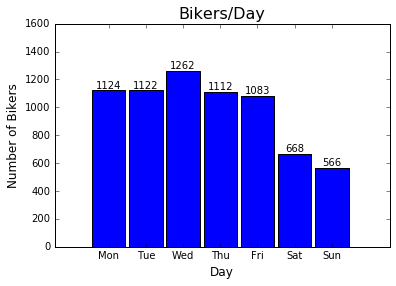

In [491]:
day = [temp.strftime("%a") for temp in start]
data = Counter(day)
names = list(calendar.day_abbr)
count = [data[t] for t in names]

index = np.arange(7)
bar_width = 0.9
rect = plt.bar(index,count,bar_width)
const = 200
plt.title('Bikers/Day',fontsize=16)
plt.ylabel('Number of Bikers',fontsize=12)
plt.xlabel('Day',fontsize=12)
plt.yticks(np.arange(0,max(count)+2*const,const))
plt.xticks(index + bar_width / 2, names)
autolabel(rect)
plt.xlim([-1,8])
# plt.show()
savefig('Total_by_Day.jpg')

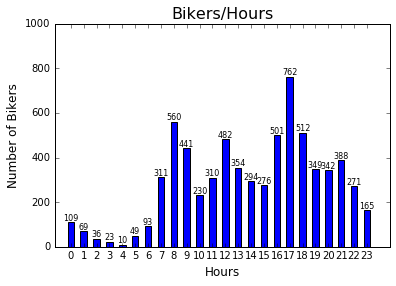

In [487]:
hour = [temp.hour for temp in start]
data = Counter(hour)
data = list(data.items())
temp = list(zip(*data))
mon = temp[0]
count = temp[1]
names = list(range(24))
index = np.arange(0,48,2)
bar_width = 1
fig,ax = plt.subplots()
rect = ax.bar(index,count,bar_width)
const = 200

plt.title('Bikers/Hours',fontsize=16)
plt.ylabel('Number of Bikers',fontsize=12)
plt.xlabel('Hours',fontsize=12)
plt.yticks(np.arange(0,max(count)+2*const,const))
ax.set_xticks(index+bar_width)
ax.set_xlim(-2, 50)
plt.xticks(index + bar_width / 2, names)
autolabel(rect)
# plt.show()
savefig('Total_by_hours.jpg')

In [496]:
purp.head().T

,0,1,2,3,4
Purpose,Commute,Commute,Commute,Commute,Commute
Start,2015-03-08T10:14:00,2015-04-15T17:53:00,2014-05-12T11:43:37,2015-05-26T09:01:00,2015-06-26T08:53:00
Stop,2015-03-08T10:32:00,2015-04-15T18:10:00,2014-05-12T11:59:05,2015-05-26T09:13:00,2015-06-26T09:02:00
TripID,12572,13114,1336,14248,15017
UserId,4,4,4,4,4
age,no data,no data,no data,no data,no data
cycling_fr,no data,no data,no data,no data,no data
ethnicity,no data,no data,no data,no data,no data
gender,no data,no data,no data,no data,no data
geometry,LINESTRING (-75.1625742281181 39.9395684976880...,LINESTRING (-75.16225129596052 39.953245133755...,LINESTRING (-75.13337403538338 39.974091209241...,LINESTRING (-75.16732257927356 39.925330932876...,LINESTRING (-75.179402654309 39.97140465550052...


In [498]:
purp.iloc[40]

Purpose                                                 Commute
Start                                       2014-08-07T18:16:06
Stop                                        2014-08-07T18:27:05
TripID                                                     8148
UserId                                                      273
age                                                     no data
cycling_fr                                                Daily
ethnicity                                               no data
gender                                                  no data
geometry      LINESTRING (-75.16409941265772 39.950094512751...
income                                                  no data
rider_hist                                        Several years
rider_type                                 Enthused & Confident
Name: 40, dtype: object

In [502]:
len(purp[purp.ethnicity=='no data'])

3685

In [555]:
counts = purp.groupby(['age','gender','ethnicity','income']).size()
counts

age      gender   ethnicity         income           
18 - 24  Female   African American  $20,000 - $39,999       2
                                    < $20,000               7
                  Asian             $20,000 - $39,999       1
                                    no data                 2
                  White             $20,000 - $39,999      19
                                    $40,000 - $59,999      14
                                    < $20,000               8
         Male     Asian             $20,000 - $39,999       7
                  Multi-racial      < $20,000               1
                  Other             $40,000 - $59,999       5
                                    < $20,000              12
                  White             $20,000 - $39,999      10
                                    $40,000 - $59,999      28
                                    $60,000 - $74,999       1
                                    < $20,000              14
                

In [556]:
temp = list(counts.index)

In [557]:
def f(x):
    if not re.findall('no',x):
        return True
    return False
t = [t for t in temp if False not in list(map(f,t))]
t

[('18 - 24', 'Female', 'African American', '$20,000 - $39,999'),
 ('18 - 24', 'Female', 'African American', '< $20,000'),
 ('18 - 24', 'Female', 'Asian', '$20,000 - $39,999'),
 ('18 - 24', 'Female', 'White', '$20,000 - $39,999'),
 ('18 - 24', 'Female', 'White', '$40,000 - $59,999'),
 ('18 - 24', 'Female', 'White', '< $20,000'),
 ('18 - 24', 'Male', 'Asian', '$20,000 - $39,999'),
 ('18 - 24', 'Male', 'Multi-racial', '< $20,000'),
 ('18 - 24', 'Male', 'Other', '$40,000 - $59,999'),
 ('18 - 24', 'Male', 'Other', '< $20,000'),
 ('18 - 24', 'Male', 'White', '$20,000 - $39,999'),
 ('18 - 24', 'Male', 'White', '$40,000 - $59,999'),
 ('18 - 24', 'Male', 'White', '$60,000 - $74,999'),
 ('18 - 24', 'Male', 'White', '< $20,000'),
 ('25 - 34', 'Female', 'Asian', '$20,000 - $39,999'),
 ('25 - 34', 'Female', 'Asian', '$40,000 - $59,999'),
 ('25 - 34', 'Female', 'White', '$20,000 - $39,999'),
 ('25 - 34', 'Female', 'White', '$40,000 - $59,999'),
 ('25 - 34', 'Female', 'White', '$60,000 - $74,999'),
 

In [559]:
t2 = [counts[temp] for temp in t]
t2

[2,
 7,
 1,
 19,
 14,
 8,
 7,
 1,
 5,
 12,
 10,
 28,
 1,
 14,
 1,
 21,
 53,
 117,
 40,
 37,
 6,
 84,
 3,
 1,
 34,
 1,
 1,
 34,
 320,
 129,
 70,
 39,
 212,
 6,
 3,
 3,
 26,
 304,
 2,
 3,
 51,
 1,
 38,
 37,
 123,
 64,
 239,
 89,
 77,
 8,
 1,
 3,
 21,
 2,
 91,
 8,
 2,
 2,
 2,
 8,
 8,
 5,
 9,
 1,
 9,
 17,
 119]

In [554]:
purp.head().T

,0,1,2,3,4
Purpose,Commute,Commute,Commute,Commute,Commute
Start,2015-03-08T10:14:00,2015-04-15T17:53:00,2014-05-12T11:43:37,2015-05-26T09:01:00,2015-06-26T08:53:00
Stop,2015-03-08T10:32:00,2015-04-15T18:10:00,2014-05-12T11:59:05,2015-05-26T09:13:00,2015-06-26T09:02:00
TripID,12572,13114,1336,14248,15017
UserId,4,4,4,4,4
age,no data,no data,no data,no data,no data
cycling_fr,no data,no data,no data,no data,no data
ethnicity,no data,no data,no data,no data,no data
gender,no data,no data,no data,no data,no data
geometry,LINESTRING (-75.1625742281181 39.9395684976880...,LINESTRING (-75.16225129596052 39.953245133755...,LINESTRING (-75.13337403538338 39.974091209241...,LINESTRING (-75.16732257927356 39.925330932876...,LINESTRING (-75.179402654309 39.97140465550052...


In [567]:
purp[purp.UserId=='273']

,Purpose,Start,Stop,TripID,UserId,age,cycling_fr,ethnicity,gender,geometry,income,rider_hist,rider_type
40,Commute,2014-08-07T18:16:06,2014-08-07T18:27:05,8148,273,no data,Daily,no data,no data,LINESTRING (-75.16409941265772 39.950094512751...,no data,Several years,Enthused & Confident
1299,Commute,2014-08-07T08:55:07,2014-08-07T09:08:54,8122,273,no data,Daily,no data,no data,LINESTRING (-75.17440143447857 39.932964603233...,no data,Several years,Enthused & Confident
1749,Commute,2014-08-06T17:19:56,2014-08-06T18:00:08,8085,273,no data,Daily,no data,no data,LINESTRING (-75.16577456364513 39.950319197572...,no data,Several years,Enthused & Confident
2954,Commute,2014-08-06T08:44:00,2014-08-06T09:10:06,8123,273,no data,Daily,no data,no data,LINESTRING (-75.17368658766583 39.936276296414...,no data,Several years,Enthused & Confident
3774,Errand,2014-08-05T12:01:50,2014-08-05T12:26:27,8041,273,no data,Daily,no data,no data,LINESTRING (-75.16426973436069 39.949343571648...,no data,Several years,Enthused & Confident
3795,Errand,2014-08-05T12:26:36,2014-08-05T12:46:56,7998,273,no data,Daily,no data,no data,LINESTRING (-75.14729268171186 39.942854855167...,no data,Several years,Enthused & Confident
5872,Social,2014-08-05T20:19:37,2014-08-05T20:30:41,8028,273,no data,Daily,no data,no data,LINESTRING (-75.1775562481223 39.9333660785817...,no data,Several years,Enthused & Confident
6047,Social,2014-08-05T20:45:18,2014-08-05T20:54:30,8033,273,no data,Daily,no data,no data,LINESTRING (-75.17182114642873 39.937462718929...,no data,Several years,Enthused & Confident


In [599]:
temp = [sum(purp[column]=='no data') for column in purp]
temp

[0, 0, 0, 0, 0, 3519, 3416, 3685, 3594, 0, 4104, 3381, 3418]

In [612]:
len(purp[purp.UserId=='4'])

3155

In [611]:
t1 = list(zip(list(purp.columns),temp))
t1

[('Purpose', 0),
 ('Start', 0),
 ('Stop', 0),
 ('TripID', 0),
 ('UserId', 0),
 ('age', 3519),
 ('cycling_fr', 3416),
 ('ethnicity', 3685),
 ('gender', 3594),
 ('geometry', 0),
 ('income', 4104),
 ('rider_hist', 3381),
 ('rider_type', 3418)]

In [614]:
temp2 = [Counter(purp[purp[column]=='no data'].UserId) for column in purp]
t2 = [t["4"] for t in temp2]
t2

[0, 0, 0, 0, 0, 3155, 3155, 3155, 3155, 0, 3155, 3155, 3155]

In [598]:
list(zip(list(purp.columns),list(np.array(temp)-np.array(t2))))

[('Purpose', 0),
 ('Start', 0),
 ('Stop', 0),
 ('TripID', 0),
 ('UserId', 0),
 ('age', 364),
 ('cycling_fr', 261),
 ('ethnicity', 530),
 ('gender', 439),
 ('geometry', 0),
 ('income', 949),
 ('rider_hist', 226),
 ('rider_type', 263)]

In [626]:
temp3 = [set(purp[purp[column]=='no data'].UserId) for column in purp]
temp3

[set(),
 set(),
 set(),
 set(),
 set(),
 {'119',
  '12',
  '133',
  '143',
  '148',
  '212',
  '222',
  '223',
  '24',
  '25',
  '273',
  '274',
  '305',
  '310',
  '314',
  '320',
  '342',
  '344',
  '35',
  '382',
  '4',
  '400',
  '47',
  '74',
  '90'},
 {'100',
  '108',
  '119',
  '122',
  '129',
  '133',
  '143',
  '148',
  '152',
  '166',
  '175',
  '212',
  '220',
  '24',
  '25',
  '270',
  '278',
  '293',
  '305',
  '314',
  '320',
  '333',
  '338',
  '342',
  '344',
  '35',
  '357',
  '379',
  '382',
  '4',
  '405',
  '50',
  '74',
  '81',
  '90'},
 {'119',
  '12',
  '129',
  '133',
  '143',
  '148',
  '168',
  '212',
  '219',
  '223',
  '234',
  '24',
  '25',
  '267',
  '273',
  '274',
  '305',
  '310',
  '314',
  '320',
  '327',
  '342',
  '344',
  '35',
  '37',
  '379',
  '382',
  '4',
  '400',
  '407',
  '43',
  '47',
  '74',
  '87',
  '90'},
 {'119',
  '12',
  '133',
  '143',
  '148',
  '212',
  '222',
  '223',
  '24',
  '25',
  '263',
  '273',
  '305',
  '310',
  '314',


In [629]:
temp3 = [t for t in temp3 if t]


In [633]:
t4 = set.intersection(*temp3)

In [635]:
temp4 = Counter(purp.UserId)
t5 = [temp4[t] for t in t4]
list(zip(t4,t5))

[('212', 12),
 ('344', 29),
 ('314', 3),
 ('320', 9),
 ('119', 1),
 ('74', 3),
 ('133', 4),
 ('305', 9),
 ('90', 5),
 ('143', 1),
 ('35', 1),
 ('382', 1),
 ('4', 3155),
 ('148', 1),
 ('25', 5),
 ('342', 4),
 ('24', 124)]